 # DOGGO GAN CLASSIFICATOR

## Import

In [0]:
!pip install tqdm

In [0]:

#!pip show tqdm
import os
import os.path
import sys
from skimage import io
import shutil
import logging
import pandas as pd
import numpy as np
from datetime import datetime
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader, random_split
from torch.backends import cudnn
from torch.nn.utils import spectral_norm
from torch.autograd import Variable

import torchvision
from torchvision import transforms
from torchvision.models import alexnet, vgg11_bn, squeezenet1_0, densenet121, inception_v3
from torchvision.datasets import VisionDataset
import torchvision.utils as vutils
from torchvision.utils import save_image

from PIL import Image
import tqdm

import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.pyplot import imshow
from copy import deepcopy
import time
import xml.etree.ElementTree as ET

# generate random integer values
from random import seed
from random import randint
# seed random number generator
seed(1)


## Download datasets from Github (or local..)

In [0]:
# Clone github repository with data
if os.path.isdir('dataset'):
    root_dir='./'
else:
    root_dir='./doggo_gan/'
    # Clone github repository with data
    if not os.path.isdir('./doggo_gan'):
      !git clone 'https://gitlab.com/isnob46/doggo_gan.git'


In [0]:
DEVICE = 'cuda' 
def donetime(start=None):
  if start != None:
    if ((time.time() - start)/60) < 60:
      print('DONE (time {:4.2f} m)'.format((time.time() - start)/60))
    else:
      print('DONE (time {:4.2f} h)'.format((time.time() - start)/3600))
  else:
    print('\nDONE')
  return

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor


def show_batch_images(dataset,batch_size,title=''):
  fig, axs = plt.subplots(1, batch_size,figsize=(15, 3), dpi=80, facecolor='white')
  for i in range(batch_size):
    n=randint(0,len(dataset))
    im,label=dataset[n]
    unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    im=unorm(im)
    axs[i].imshow(im.permute(1,2,0))
    axs[i].set_title(list(dataset.class_to_idx.keys())[label] )
    axs[i].get_xaxis().set_visible(False)
    axs[i].get_yaxis().set_visible(False)
  plt.subplots_adjust(wspace=0, hspace=0)
  plt.show()

def show_grid_samples(dataset,title='dataset samples',size=32):
    # visualization batch image
    images=[]
    for i in range(size):
      n=randint(0,len(dataset))
      im,label=dataset[n]
      images.append(im)
    plt.figure(figsize=(20,20))
    plt.axis("off")
    plt.title(title)
    image = np.transpose(vutils.make_grid(images, normalize=True).cpu(),axes=(1,2,0))
    plt.imshow(image)
    plt.show()

## Transforms

In [0]:
# This is the old transform. New ones should look like the ones below.
random_transforms = [transforms.ColorJitter(),transforms.RandomRotation(degrees=20)]
gan_transform = transforms.Compose([transforms.Resize((256,256)),
                                 transforms.RandomHorizontalFlip(p=0.5),
                                 transforms.RandomApply(random_transforms, p=0.3),
                                 transforms.CenterCrop(224), 
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # Normalizes tensor with mean and standard deviation of ImageNet
])

test_transform = transforms.Compose([transforms.Resize((256,256)),
                                 transforms.CenterCrop(224), 
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # Normalizes tensor with mean and standard deviation of ImageNet
])



## Load datasets

-----------------------------------STOCK DATASET-----------------------------------
Stock Dataset loaded: 20580
Stock Dataset classes: 120


-----------------------------------GENERATED DATASET-----------------------------------
Generated Dataset loaded: 30000
Generated Dataset classes: 120


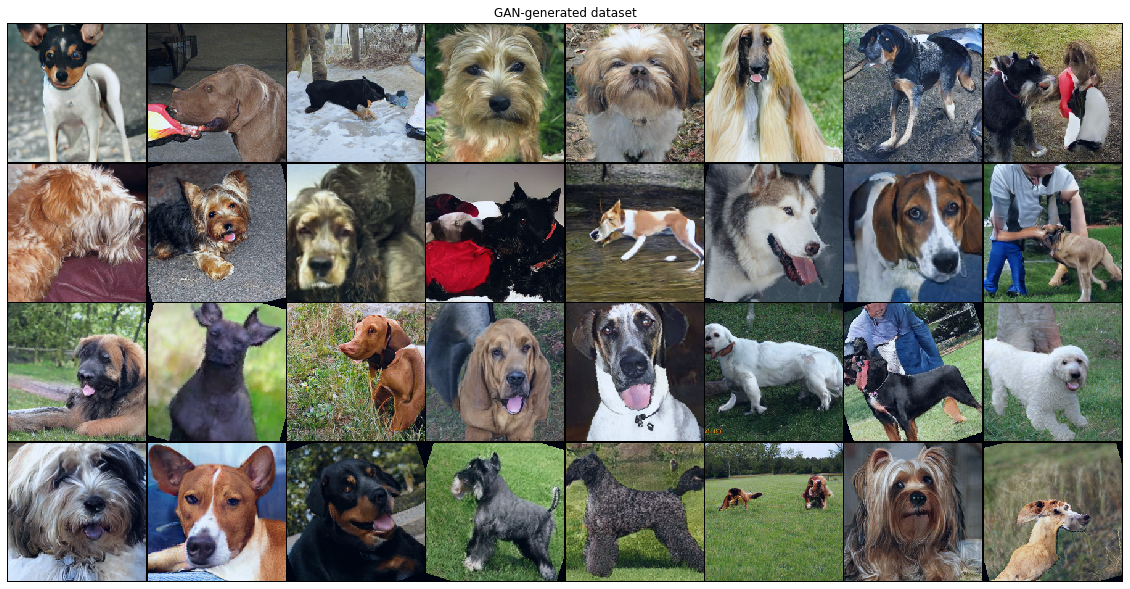

In [5]:
DEVICE = 'cuda' 
NUM_CLASSES = 120
BATCH_SIZE = 256 
stock_dir='dataset_clean/images'
generated_dir='dataset_augmentated/images'
dataset_stock = torchvision.datasets.ImageFolder(
    root_dir+stock_dir,
    transform=gan_transform
)

dataset_generated = torchvision.datasets.ImageFolder(
    root_dir+generated_dir,
    transform=gan_transform
)

print('-----------------------------------STOCK DATASET-----------------------------------')
print('Stock Dataset loaded:',len(dataset_stock))
print('Stock Dataset classes:',len(dataset_stock.classes))
show_grid_samples(dataset_stock,title='stock dataset')

print('-----------------------------------GENERATED DATASET-----------------------------------')
print('Generated Dataset loaded:',len(dataset_generated))
print('Generated Dataset classes:',len(dataset_generated.classes))
show_grid_samples(dataset_generated,title='GAN-generated dataset')

## Split dataset (train and test) and then concatenate with augmentated dataset

In [99]:
#Split the dataset in traning, validation and test 
torch.manual_seed(42) #manual seed for random (reproducible) test set generator
print('Manual seed',torch.initial_seed())
size = len(dataset_stock)

test_size = int(np.trunc(0.2*size))
train_size = size - test_size

train_dataset_stock, test_dataset = torch.utils.data.random_split(dataset_stock, [train_size, test_size])
train_dataset_augmentated = torch.utils.data.ConcatDataset([train_dataset_stock, dataset_generated])


print("Train (stock dataset): ", len(train_dataset_stock) ," / ", len(dataset_stock), "loaded -> ", 100*(train_size/size), "% of stock Dataset")
print("Train (augmentated dataset): ", len(train_dataset_augmentated) ," / ", len(dataset_stock), "loaded -> {:.2f} % of stock Dataset".format(100*(len(train_dataset_augmentated) /size)))
print("Test (stock dataset): ", len(test_dataset)," / ", len(dataset_stock), "loaded -> ", 100*(test_size/size), "% of stock Dataset")

test_dataset.dataset.transform = test_transform # apply test transform (no random transforms)



Manual seed 42
Train (stock dataset):  16464  /  20580 loaded ->  80.0 % of stock Dataset
Train (augmentated dataset):  46464  /  20580 loaded -> 225.77 % of stock Dataset
Test (stock dataset):  4116  /  20580 loaded ->  20.0 % of stock Dataset


## Train functions

In [0]:
#Arrays used to compute stats
times = [] #All training times will be appended here
test_time = []  #All test times will be appended here
model_accuracy = [] #All final accuracy value 
accuracy = [] #All the accuracy values
lost = [] #All the loss values

def graph_train(NUM_EPOCHS, title=''):

  #This is a utility function used to plot the results
  #of the last NUM_EPOCHS loss and accuracy values 
  #i.e. the last training's results
  fig, (ax1, ax2) = plt.subplots(1,2,facecolor='white')
  ax1.set_title("Loss")
  ax2.set_title("Accuracy")
  if title != '':
    fig.suptitle(title + "\n", fontsize=12)
  ax1.plot(lost[-NUM_EPOCHS:], 'bo-')
  ax2.plot(accuracy[-NUM_EPOCHS:], 'bo-')
  ax1.grid(True)
  ax2.grid(True)
  ax1.set(xlabel ="Epoch", ylabel = "Loss")
  ax2.set(xlabel ="Epoch", ylabel = "Accuracy")
  plt.tight_layout()
  plt.show()
def plot_loss(losses, epoch,title='Loss graph',):
    plt.figure(figsize=(10,5),facecolor='white')
    plt.title( title +' epochs: ' + str(epoch))
    plt.plot(losses)
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.grid()
    plt.show()
    
def plot_barh(class_accuracy):
  plt.figure(figsize=(10,22),facecolor='white')
  plt.title("Accuracy for each class")
  plt.grid()
  plt.barh(list(class_accuracy.keys()),class_accuracy.values())
  plt.show()

def plot_dual_loss(losses_1, losses_2, epoch=20,label1='net1',label2='net2'):
    plt.figure(figsize=(10,5),facecolor='white')
    plt.title("Generator and Discriminator Loss - EPOCH "+ str(epoch))
    plt.plot(losses_1,label=label1)
    plt.plot(losses_2,label=label2)
    plt.grid()
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
def top_k(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


def perform_test(net, test_dataloader):
  #This function performs accuracy tests on a provided trained cnn (net)
  #using a given dataloader
  classes=test_dataloader.dataset.dataset.classes
  num_classes=len(classes)
  net.eval() # Set Network to evaluation mode
  running_corrects = 0
  class_correct = list(0. for i in range(num_classes))
  class_total = list(0. for i in range(num_classes))
  #tot_outputs=torch.tensor([])
  #test_start = datetime.now()                 #Used to monitor training time
  for images, labels in test_dataloader:
    
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)
    batch_size=labels.size(0)
    outputs = net(images)# Forward Pass
    _, preds = torch.max(outputs.data, 1)# Get predictions
    c = (preds == labels).squeeze()
    running_corrects += torch.sum(preds == labels.data).data.item()# Update Corrects
    for i in range(batch_size):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
  # Calculate Accuracy
  accuracy = 100*(running_corrects / float(len(test_dataloader.dataset)))
  class_accuracy={}
  for i in range(num_classes): #accyracy for class
    class_accuracy[classes[i]]= 100 * class_correct[i] / class_total[i]

  net.train(True) # Set Network to evaluation mode
  print('Total Accuracy',accuracy)
  return accuracy,class_accuracy


def train_net(net, train_dataloader,  optimizer_name='SGD', 
              batch_size=256, learning_rate=1e-3, momentum=0.9, weight_decay=5e-5, 
              epochs_n=30, step_size=20, gamma=0.1,log_frequency=20, eps=None, rho=None, model_description=''):

  #This function trains a given network on a given train_dataloader, 
  # And plot the results. Different optimizers can be used, and optimizer parameters
  #different to the default ones can be passed if desired. 

  net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
  cudnn.benchmark # Calling this optimizes runtime

  #OPTIMEZER PARAMS:
  #Implementation could be improved using the param object. 
  BATCH_SIZE = batch_size      # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                               # the batch size, learning rate should change by the same factor to have comparable results
  LR = learning_rate           # The initial Learning Rate
  MOMENTUM = momentum          # Hyperparameter for SGD, keep this at 0.9 when using SGD
  WEIGHT_DECAY = weight_decay  # Regularization, you can keep this at the default
  NUM_EPOCHS = epochs_n        # Total number of training epochs (iterations over dataset)
  STEP_SIZE = step_size        # How many epochs before decreasing learning rate (if using a step-down policy)
  GAMMA = gamma                # Multiplicative factor for learning rate step-down
  LOG_FREQUENCY = log_frequency
  EPS = eps

  #Loss, opt and scheduler initialization for chosen strategy
  if(optimizer_name == 'SGD'):
    criterion = nn.CrossEntropyLoss()         
    parameters_to_optimize = net.parameters() 
    optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
  if(optimizer_name == 'Adam'):
    criterion = nn.CrossEntropyLoss()        
    parameters_to_optimize = net.parameters() 
    optimizer = optim.Adam(parameters_to_optimize,lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
  if(optimizer_name == 'Ada'):
    criterion = nn.CrossEntropyLoss() 
    parameters_to_optimize = net.parameters() 
    optimizer = optim.Adadelta(parameters_to_optimize,lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

  current_step = 0 #scheduler steps 
  startTime = time.time() #Used to monitor training time
  losses=[]
  for epoch in range(NUM_EPOCHS): # Start iterating over the epochs
    current_step=0
    print('Epoch [{}/{}], LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))
    for images, labels in train_dataloader:
      images = images.to(DEVICE)        # Bring data over the device of choice
      labels = labels.to(DEVICE)        # Bring data over the device of choice

      net.train()                       # Sets module in training mode
      optimizer.zero_grad()             # Zero-ing the gradients
      
      outputs = net(images)             # Forward pass to the network
      loss = criterion(outputs, labels) # Compute loss based on output and ground truth
      
      # Compute gradients for each layer and update weights
      loss.backward()                   # backward pass: computes gradients
      
      if current_step % log_frequency == 0:
        print('\t [{}/{}] loss:{:.3f}'.format(current_step,len(train_dataloader),loss.item()))
      optimizer.step()                  # update weights based on accumulated gradients    
      current_step += 1
    losses.append(loss.item())
    # Step the scheduler
    scheduler.step()

  plot_loss(losses,NUM_EPOCHS,title="Alexnet Loss")
  donetime(startTime)
  return losses

# AlexNet (stock params) lr: 0.01 20 epochs step 15




## Train and test (stock dataset)

Epoch [1/20], LR = [0.01]
	 [0/65] loss:5.159
	 [50/65] loss:1.915
Epoch [2/20], LR = [0.01]
	 [0/65] loss:1.542
	 [50/65] loss:1.394
Epoch [3/20], LR = [0.01]
	 [0/65] loss:1.143
	 [50/65] loss:1.197
Epoch [4/20], LR = [0.01]
	 [0/65] loss:0.931
	 [50/65] loss:0.952
Epoch [5/20], LR = [0.01]
	 [0/65] loss:0.732
	 [50/65] loss:0.795
Epoch [6/20], LR = [0.01]
	 [0/65] loss:0.572
	 [50/65] loss:0.487
Epoch [7/20], LR = [0.01]
	 [0/65] loss:0.359
	 [50/65] loss:0.439
Epoch [8/20], LR = [0.01]
	 [0/65] loss:0.283
	 [50/65] loss:0.335
Epoch [9/20], LR = [0.01]
	 [0/65] loss:0.329
	 [50/65] loss:0.343
Epoch [10/20], LR = [0.01]
	 [0/65] loss:0.200
	 [50/65] loss:0.282
Epoch [11/20], LR = [0.001]
	 [0/65] loss:0.222
	 [50/65] loss:0.089
Epoch [12/20], LR = [0.001]
	 [0/65] loss:0.054
	 [50/65] loss:0.065
Epoch [13/20], LR = [0.001]
	 [0/65] loss:0.092
	 [50/65] loss:0.042
Epoch [14/20], LR = [0.001]
	 [0/65] loss:0.052
	 [50/65] loss:0.049
Epoch [15/20], LR = [0.001]
	 [0/65] loss:0.056
	 [50

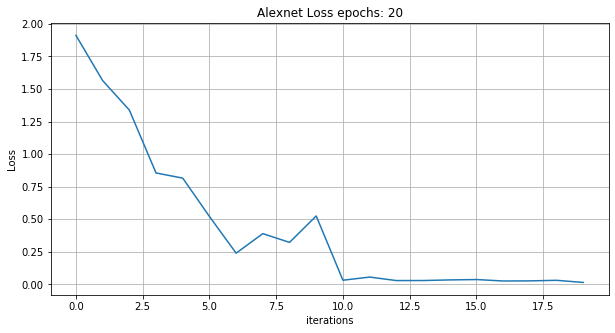

DONE (time 29.51 m)
Total Accuracy 63.60544217687075


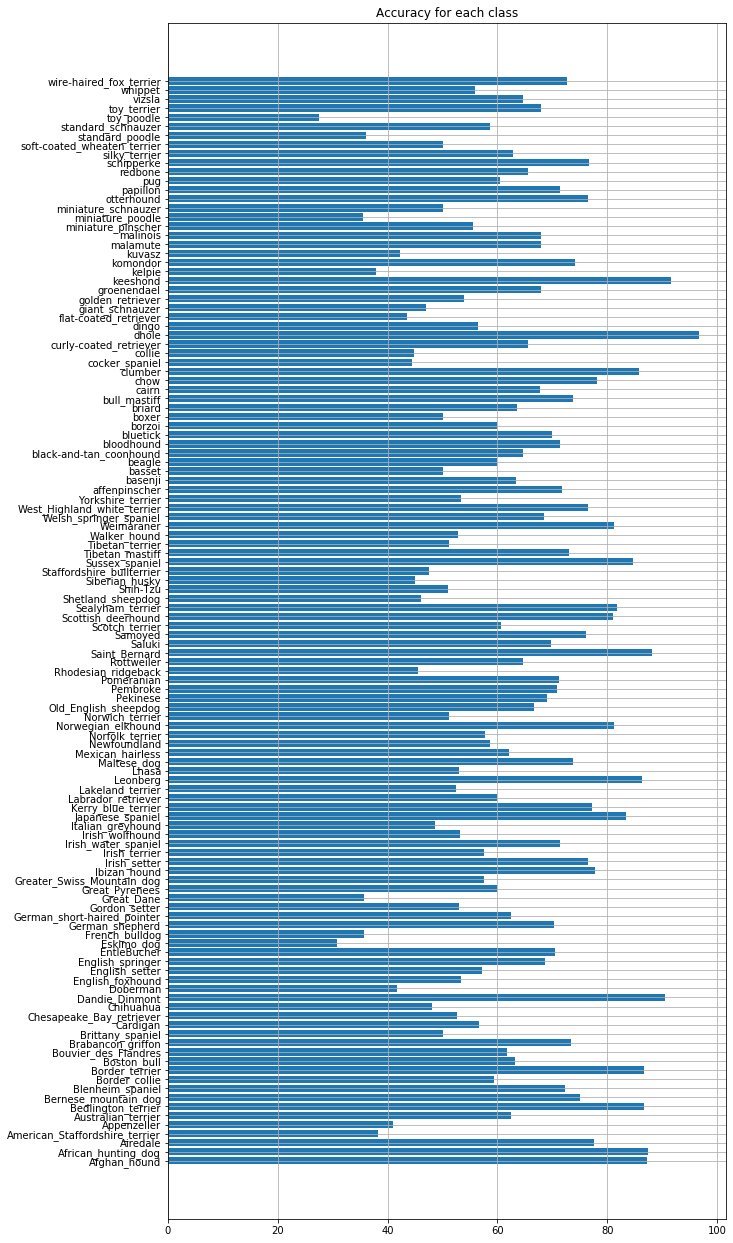

In [93]:
train_dataloader_stock=DataLoader(train_dataset_stock, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
test_dataloader=DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)


alexnet_stock = alexnet(pretrained=True) # Loading AlexNet model
alexnet_stock.classifier[6] = nn.Linear(4096, NUM_CLASSES)

loss_alexnet_stock=train_net(alexnet_stock, train_dataloader_stock, learning_rate=0.01,epochs_n=20,step_size=10,log_frequency=50, model_description='AlexNet (stock)')
accuracy_alexnet_stock,acc_class_alexnet_stock=perform_test(alexnet_stock, test_dataloader)

plot_barh(acc_class_alexnet_stock)


## Train and test (augmentated dataset)

Epoch [1/20], LR = [0.01]
	 [0/182] loss:5.336
	 [100/182] loss:1.300
Epoch [2/20], LR = [0.01]
	 [0/182] loss:0.919
	 [100/182] loss:0.946
Epoch [3/20], LR = [0.01]
	 [0/182] loss:0.795
	 [100/182] loss:0.930
Epoch [4/20], LR = [0.01]
	 [0/182] loss:0.599
	 [100/182] loss:0.710
Epoch [5/20], LR = [0.01]
	 [0/182] loss:0.620
	 [100/182] loss:0.672
Epoch [6/20], LR = [0.01]
	 [0/182] loss:0.457
	 [100/182] loss:0.427
Epoch [7/20], LR = [0.01]
	 [0/182] loss:0.401
	 [100/182] loss:0.489
Epoch [8/20], LR = [0.01]
	 [0/182] loss:0.351
	 [100/182] loss:0.424
Epoch [9/20], LR = [0.01]
	 [0/182] loss:0.378
	 [100/182] loss:0.329
Epoch [10/20], LR = [0.01]
	 [0/182] loss:0.222
	 [100/182] loss:0.348
Epoch [11/20], LR = [0.001]
	 [0/182] loss:0.241
	 [100/182] loss:0.103
Epoch [12/20], LR = [0.001]
	 [0/182] loss:0.165
	 [100/182] loss:0.086
Epoch [13/20], LR = [0.001]
	 [0/182] loss:0.142
	 [100/182] loss:0.110
Epoch [14/20], LR = [0.001]
	 [0/182] loss:0.144
	 [100/182] loss:0.127
Epoch [15/2

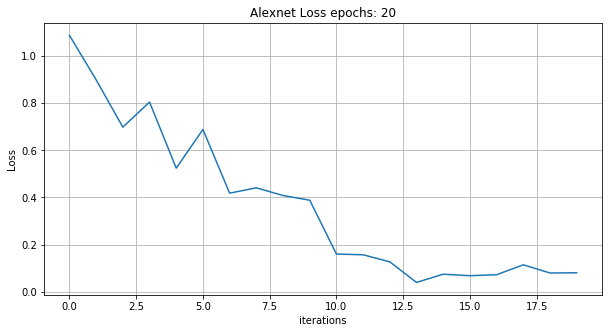

DONE (time 1.16 h)
Total Accuracy 62.585034013605444
Accuracy: 62.585034013605444


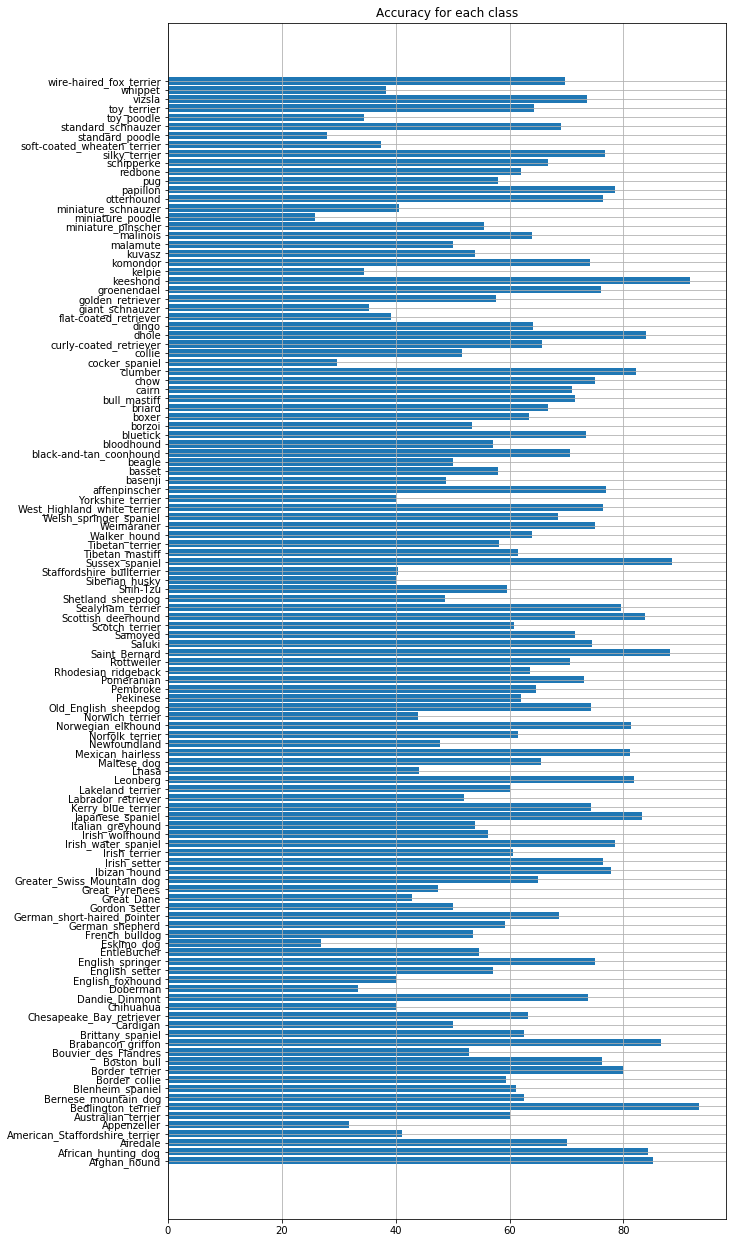

In [95]:
train_dataloader_augment=DataLoader(train_dataset_augmentated, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
test_dataloader=DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)


net_alexnet_aug = alexnet(pretrained=True) # Loading AlexNet model
net_alexnet_aug.classifier[6] = nn.Linear(4096, NUM_CLASSES)

loss_alexnet_augmentated=train_net(net_alexnet_aug, train_dataloader_augment,learning_rate=0.01,epochs_n=20,step_size=10,log_frequency=100, model_description='AlexNet (Augmentated)')
accuracy_alexnet_augmentated,acc_class_alexnet_aug=perform_test(net_alexnet_aug, test_dataloader)
print('Accuracy: {}'.format(accuracy_alexnet_augmentated))
plot_barh(acc_class_alexnet_aug)


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type AlexNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist

In [0]:
torch.save(alexnet_stock.state_dict(),'alexnet_stock_20epochs.pth')
torch.save(net_alexnet_aug.state_dict(),'alexnet_aug_20epochs.pth')


## Compare

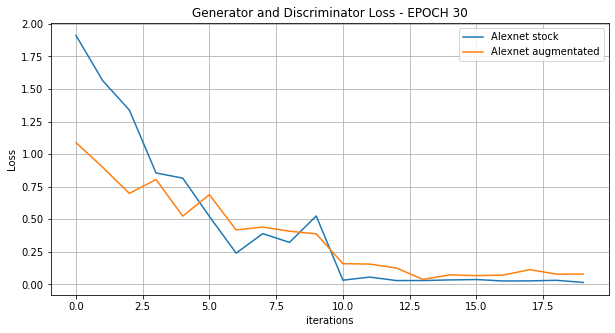

In [96]:
plot_dual_loss(loss_alexnet_stock,loss_alexnet_augmentated,epoch=30,label1='Alexnet stock',label2='Alexnet augmentated')


# VGG
### train and test

In [108]:
train_dataloader=DataLoader(train_dataset_stock, batch_size=128, shuffle=True, num_workers=8)
test_dataloader=DataLoader(test_dataset, batch_size=128, shuffle=True, num_workers=8)

vgg_stock = vgg11_bn(pretrained=True) # Loading vgg model
vgg_stock.classifier[6] = nn.Linear(4096, NUM_CLASSES)
loss_vgg_stock=train_net(vgg_stock, train_dataloader,learning_rate=0.01,epochs_n=20,step_size=10,log_frequency=50, model_description='Vgg11 (Stock)')
accuracy_vgg_stock,acc_class_vgg_stock=perform_test(vgg_stock, test_dataloader)
print('Accuracy: {}'.format(accuracy_vgg_stock))
plot_barh(acc_class_vgg_stock)

RuntimeError: ignored

##DenseNet
###Validation

In [105]:
lr = [0.0001, 0.001, 0.01]
for rate in lr:
  net3 = densenet121(pretrained=True) # Loading model
  net3.classifier = nn.Linear(1024, NUM_CLASSES)
  train_net(net3, train_dataloader, val_dataloader, learning_rate=rate)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 106MB/s]


NameError: ignored

###Test

In [0]:
best_lr = 0.01

net3 = densenet121(pretrained=True) # Loading model
net3.classifier = nn.Linear(1024, NUM_CLASSES)
train_net(net3, train_complete_dataloader, test_dataloader, learning_rate=best_lr)